# Прогноз оттока клиентов фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

Проект включает в себя:

- Предобработку данных
- Исследовательский анализ данных:
- Построение модели прогнозирования оттока клиентов
- Кластеризацию клиентов

В результате анализа, моделирования прогноза оттока икластеризации пользователей определены признаки, влияющие на отток клиентов и сформулированы рекомендации для их удержания.

## Загрузка данных

Загрузка библиотек

In [1]:
!pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 1.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

Загрузка данных:

In [3]:
data = pd.read_csv('/datasets/gym_churn.csv')

Выведем 5 случайных строк(в транспонированном виде) и общую информацию о данных:

In [4]:
data.sample(5).T

,2833,440,3908,3357,2467
gender,0.000000,1.000000,1.000000,0.000000,0.000000
Near_Location,1.000000,1.000000,1.000000,1.000000,1.000000
Partner,0.000000,0.000000,0.000000,1.000000,0.000000
Promo_friends,0.000000,0.000000,0.000000,0.000000,0.000000
Phone,1.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,1.000000,1.000000,1.000000,1.000000,1.000000
Group_visits,1.000000,0.000000,0.000000,0.000000,0.000000
Age,29.000000,27.000000,21.000000,31.000000,29.000000
Avg_additional_charges_total,5.711843,106.921928,232.306539,69.834474,165.918840
Month_to_end_contract,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Имеем 4000 записей, пропущенных значений нет. Вседанные имеют числовое значение. Данные разбиты на 14 колонок:

- 'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные клиента за предыдущий до проверки факта оттока месяц:

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

### Предобработка данных

Приведем названия колонок к нижнему регистру:

In [6]:
data.columns = [i.lower() for i in list(data.columns)]

Присвоим тип bool данным, находящимся в колонках `gender, near_location, partner, promo_friends, phone, group_visits, churn'`:

In [7]:
data[['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']] = (
    data[['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']].astype(np.bool))

Для данных в колонках `avg_additional_charges_total, avg_class_frequency_total, avg_class_frequency_current_mont` присвоим тип float32, в колонках `age, month_to_end_contract, lifetime`, `contract_period` - uint8, 

In [8]:
data[['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']] = data[
    ['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']].astype(np.float32)

data[['age', 'month_to_end_contract', 'lifetime']] = data[['age', 'month_to_end_contract', 'lifetime']].astype(np.uint8)

Выведем общую информацию о данных:

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null bool
near_location                        4000 non-null bool
partner                              4000 non-null bool
promo_friends                        4000 non-null bool
phone                                4000 non-null bool
contract_period                      4000 non-null int64
group_visits                         4000 non-null bool
age                                  4000 non-null uint8
avg_additional_charges_total         4000 non-null float32
month_to_end_contract                4000 non-null uint8
lifetime                             4000 non-null uint8
avg_class_frequency_total            4000 non-null float32
avg_class_frequency_current_month    4000 non-null float32
churn                                4000 non-null bool
dtypes: bool(7), float32(3), int64(1), uint8(3)
memory usage: 117.3 KB


Проверка на дубликаты:

In [10]:
data.duplicated().sum()

0

**Вывод:**

- Данные содержат 4000 записей, без пропущенныхзначений и дубликатов. 
- Оптимизированы названия колонок и типы значений.


## Исследовательский анализ данных

Рассмотрим распределение значений признаков в датасете:

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943726,96.355606,0.148205,68.868832,136.220161,210.949619,552.590759
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
avg_class_frequency_total,4000.0,1.879020,0.972245,0.000000,1.180875,1.832768,2.536078,6.023668
avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.000000,0.963003,1.719574,2.510336,6.146783


Далее будем называть клиентов, не попавших в отток Надёжными клиентами. Сгруппируем данные по факту оттока и найдём средние величины:

In [12]:
data.groupby('churn').mean().T.rename(columns={False:'Надёжные клиенты', True:'Клиенты в оттоке'})

churn,Надёжные клиенты,Клиенты в оттоке
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445709,115.082901
month_to_end_contract,5.283089,1.662582


Клиенты в оттоке тратят меньше чем надёжные и чаще выбирают короткие абонементы. Построим диаграммы распределения значений признаков для надёжных клиентов и ушедших в отток:

In [13]:
list_bool = [
    'churn',
    'gender', 
    'near_location', 
    'partner', 
    'promo_friends', 
    'phone', 
    'group_visits', 
    'contract_period'
]

list_num = [
    'age', 
    'avg_additional_charges_total',
    'month_to_end_contract', 
    'lifetime', 
    'avg_class_frequency_total',
    'avg_class_frequency_current_month'
]

<Figure size 432x216 with 0 Axes>

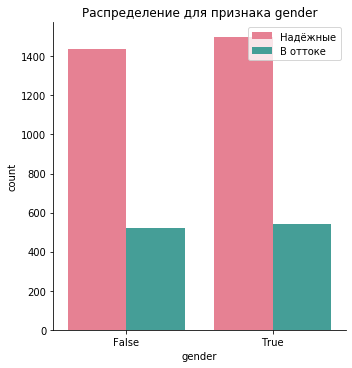

<Figure size 432x216 with 0 Axes>

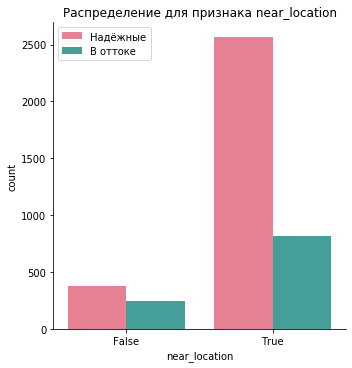

<Figure size 432x216 with 0 Axes>

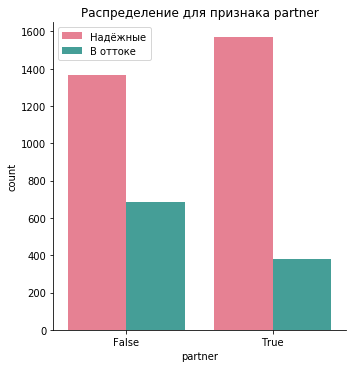

<Figure size 432x216 with 0 Axes>

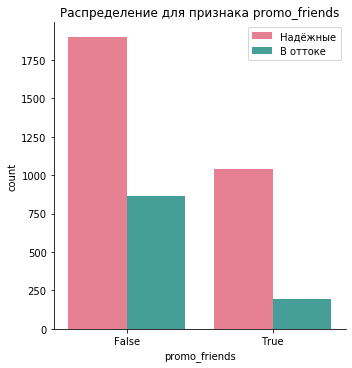

<Figure size 432x216 with 0 Axes>

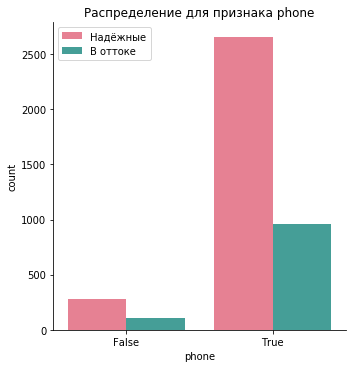

<Figure size 432x216 with 0 Axes>

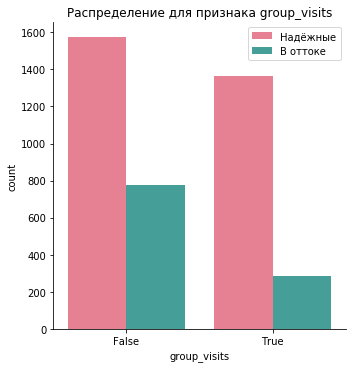

<Figure size 432x216 with 0 Axes>

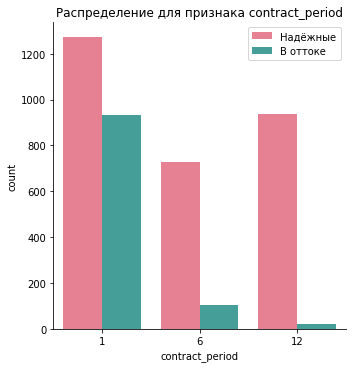

In [14]:
for i in list_bool:
    if i == 'churn':
        continue
    plt.figure(figsize = (6, 3))
    sns.catplot(i, hue='churn', data = data[list_bool], kind='count', legend=False, palette="husl")
    plt.legend(labels = ('Надёжные', 'В оттоке'))
    plt.title('Распределение для признака ' + i)
    plt.show()
    

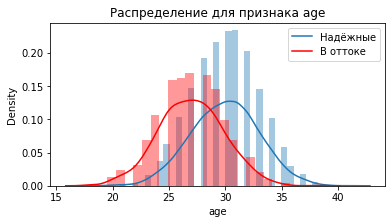

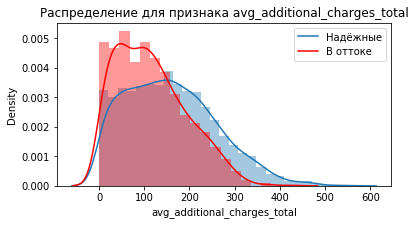

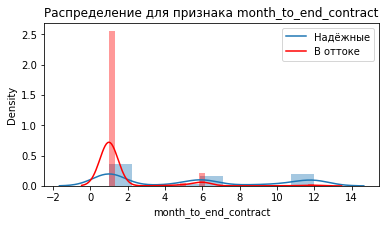

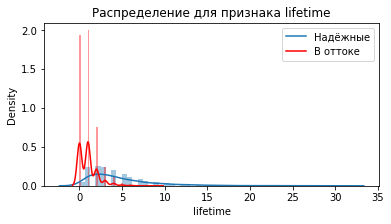

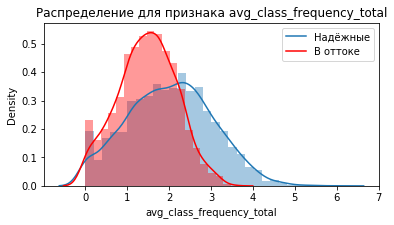

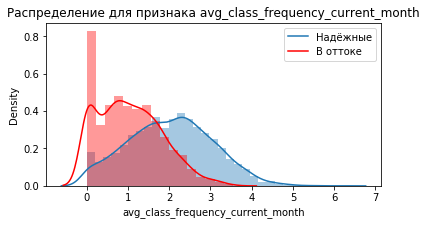

In [15]:
for i in list_num:
    plt.figure(figsize=(6, 3))
    sns.distplot(data.query('~churn')[i])
    sns.distplot(data.query('churn')[i], color = 'r')
    plt.legend(labels = ('Надёжные', 'В оттоке'))
    plt.title('Распределение для признака ' + i)
    plt.show()

Разберём влияние признаков, ориентируясь на характер распредделения:

Мы видим, что распределение полов для двух групп приблизительно одинаково - вероятно этот признак не влияет на отток клиентов. Также не оказывает влияния наличе контактного телефона.

Сравним остальные средние показатели. Надёжные клиенты, по сравнению с теми кто ушел в отток, в среднем немного старше (30 лет и 27 лет), больше тратят на дополнительные услуги (158.4 и 115.1), их занятия более регулярные и они чаще посещают групповые занятия. 

Среди клиентов в оттоке меньше тех, кто воспользовался скидкой от работодателя или друга, а так же больше клиентов, не проживающих и  не работающих в районе фитнес-клуба. Они чаще покупают абонименты на месяц.

Среди клиентов в оттоке много новых клиентов. 

In [16]:
data.query('churn')['month_to_end_contract'].mode()[0]

1

In [17]:
data.query('~churn')['month_to_end_contract'].mode()[0]

1

Для обеих групп среднее значение `month_to_end_contract` по моде равно 1 месяцу.

Предварительно, мы можем сказать, что "типичные" клиенты в оттоке покупают абонемент на один месяц, причем не по партнерской программе для работаделей или "друзей" членов клуба, а, вероятно, за полную стоимость. В течении этого месяца они редко посещают групповые занятия и реже пользуются дополнительными услугами. Посещение клуба нерегулярное, часто после покупки абонемента клиент вообще не посещает клуб и уходит в отток.  

Построим матрицу корреляций и отобразим её с помощью тепловой карты:

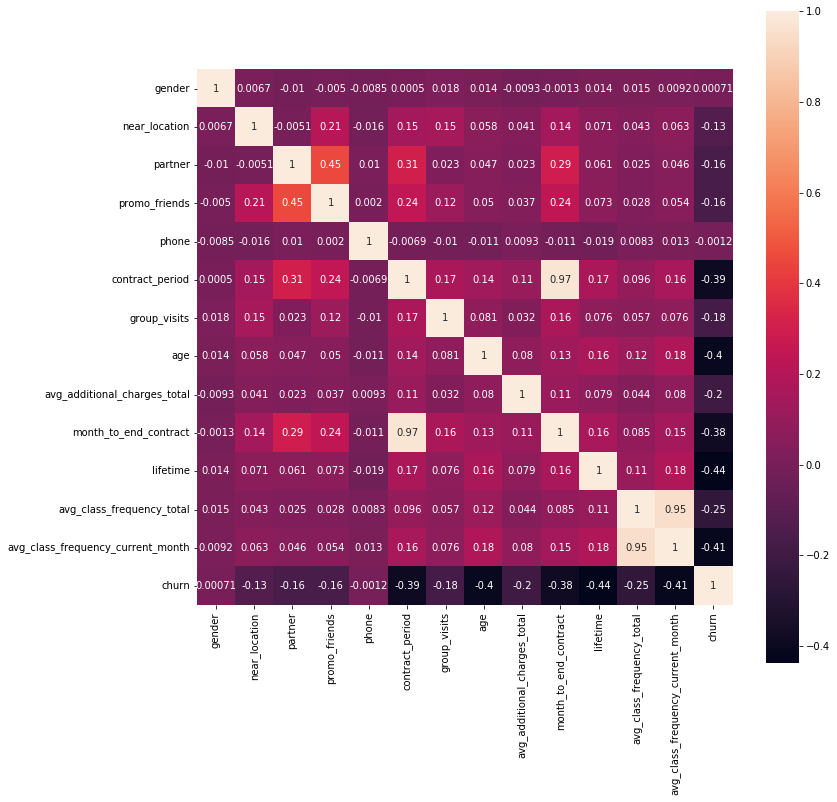

In [18]:
cm = data.corr()

plt.figure(figsize = (12, 12))
sns.heatmap(cm, annot = True, square=True)
plt.show()

Мы видим, что ожидаемо высокие значения коэффициента корреляции у пары признаков о среднем числе посещений в неделю за весь период и последний месяц, а также пары длительность абонемента/срок до окончания абонемента. 

**Вывод:**

Построив для признаков диаграммы распределения и матрицу корреляции, найдя средние значения мы можем сказать, что "типичные" клиенты в оттоке покупают абонемент на один месяц, причем не по партнерской программе для работаделей или "друзей" членов клуба, а, вероятно, за полную стоимость. В течении этого месяца они редко посещают групповые занятия и реже пользуются дополнительными услугами. Посещение клуба нерегулярное, часто после покупки абонемента клиент вообще не посещает клуб и уходит в отток.

## Построение модели прогнозирования оттока клиентов

Разделим данные на целевой переменную и признаки:

In [19]:
X = data.drop('churn', axis=1)
y = data['churn']

Разделим данные на обучающую и валидационную выборки:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом:

In [21]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
tree_pred = rf_model.predict(X_test)

Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке:

In [22]:
def print_all_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
print_all_metrics(y_test, lr_pred, title='Метрики для модели логистической регрессии:')
print_all_metrics(y_test, tree_pred, title='Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


Лучше себя показала модель логистической регрессии. Расмотрим важности признаков для модели:

In [23]:
log_reg = pd.DataFrame({'feature' : X_train.columns, 'coef' : lr_model.coef_[0]})
log_reg.sort_values(by='coef', ascending=True).reset_index(drop=True)

,feature,coef
0,avg_class_frequency_current_month,-4.059492
1,lifetime,-0.961920
2,group_visits,-0.687158
3,promo_friends,-0.494967
4,age,-0.176409
5,contract_period,-0.174077
6,month_to_end_contract,-0.081565
7,partner,-0.053407
8,avg_additional_charges_total,-0.004613
9,near_location,0.021204


Мы видим, что больше всего на отток клиентов влияет их среднее значение числа посещений клуба в неделю.

**Вывод:**
Лучше показала себя модель логистической регрессии.

## Кластеризация клиентов

Стандартизируем матрицу признаков:

In [24]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму:

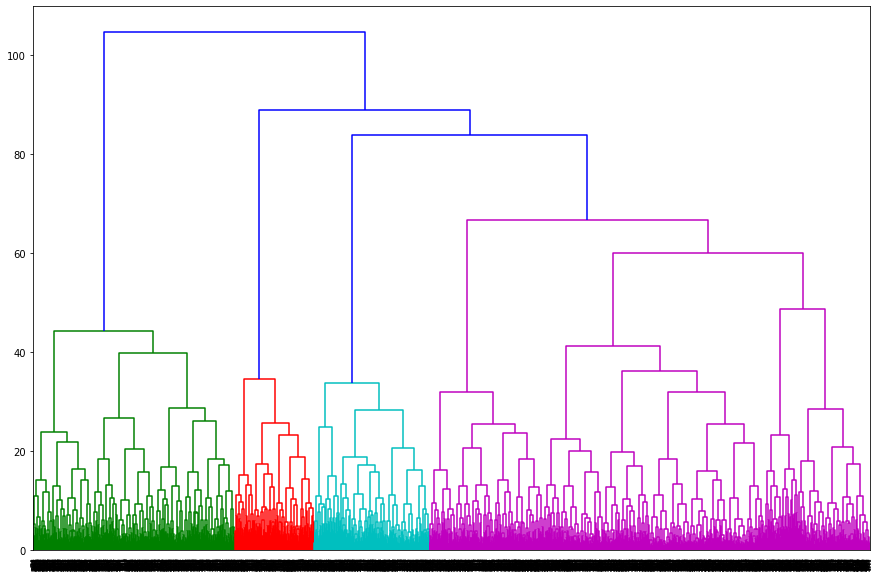

In [25]:
linked = linkage(X_st, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Предложенное оптимальное число кластеров 4.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Число кластеров примем равным пяти по условию задания n=5:

In [26]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_st)

Добавим в данные столбец с индексами кластеров:

In [27]:
data['claster_km'] = labels

Посмотрим на средние значения признаков для кластеров:

In [28]:
data.drop('churn', axis=1).groupby('claster_km').mean().T

claster_km,0,1,2,3,4
gender,0.502473,0.522078,0.495050,0.485737,0.560335
near_location,0.959446,0.862338,0.000000,1.000000,0.976105
partner,0.783383,0.470130,0.463366,0.350238,0.356033
promo_friends,0.574679,0.306494,0.079208,0.240095,0.229391
phone,1.000000,0.000000,1.000000,1.000000,0.998805
contract_period,10.884273,4.787013,2.352475,1.948494,2.665472
group_visits,0.543027,0.425974,0.215842,0.341521,0.473118
age,29.980218,29.301299,28.477228,28.167987,30.127838
avg_additional_charges_total,160.706970,143.957657,135.457504,131.622208,161.724258
month_to_end_contract,9.950544,4.475325,2.198020,1.856577,2.455197


Отметим, что

- Гендерное распределение, возраст.
- Признак принадлежности к локации клуба наиболее характерен для кластера "3", и минималендля кластера "2".
- Больше всего скидкой для партнеров или "друзей" воспользовались в кластере "0"
- В кластер "1" выделены клиенты без контактного телефона
- В кластере "0" наибольшее число посещения групповых занятий, минимальное в кластере "2"
- На дополниительные услуги больше потратили в кластерах "4" и "0"
- Самые частые тренировки в неделю в кластере "4", самые редкие - в кластере "3"


Построим распределения признаков по кластерам:

In [29]:
list_bool = [
    'claster_km',
    'gender',
    'near_location',
    'partner',
    'promo_friends',
    'phone',
    'group_visits',
    'contract_period'
]

<Figure size 432x216 with 0 Axes>

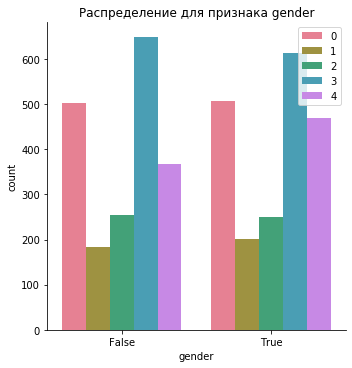

<Figure size 432x216 with 0 Axes>

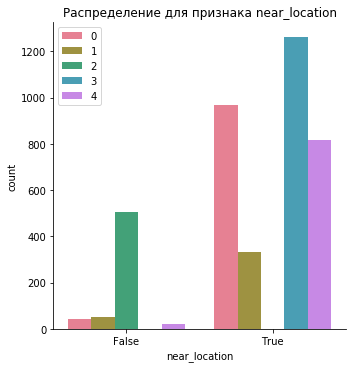

<Figure size 432x216 with 0 Axes>

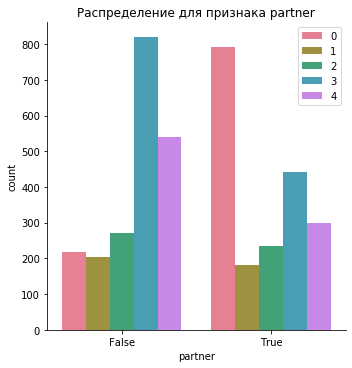

<Figure size 432x216 with 0 Axes>

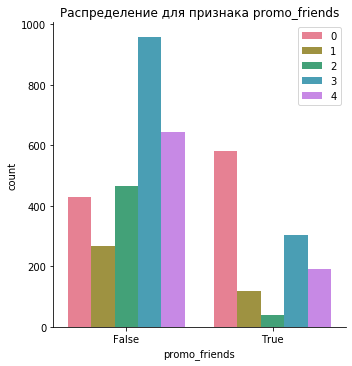

<Figure size 432x216 with 0 Axes>

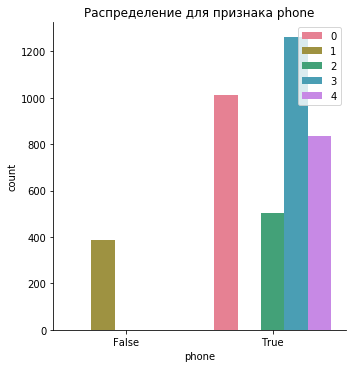

<Figure size 432x216 with 0 Axes>

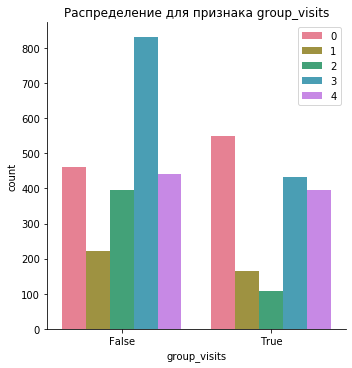

<Figure size 432x216 with 0 Axes>

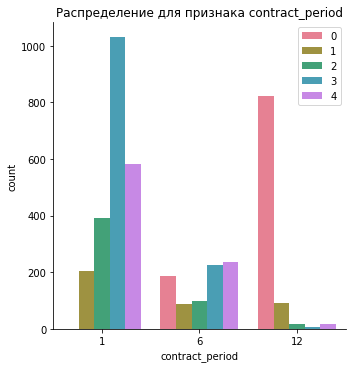

In [30]:
for i in list_bool:
    if i == 'claster_km':
        continue
    plt.figure(figsize = (6, 3))
    sns.catplot(i, hue='claster_km', data = data[list_bool], kind='count', legend=False, palette="husl")
    plt.legend(labels = ('0', '1', '2', '3', '4'))
    plt.title('Распределение для признака ' + i)
    plt.show()

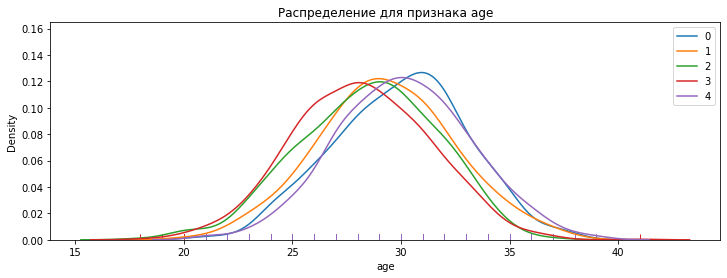

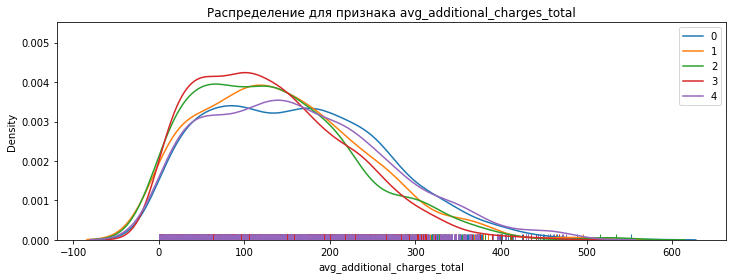

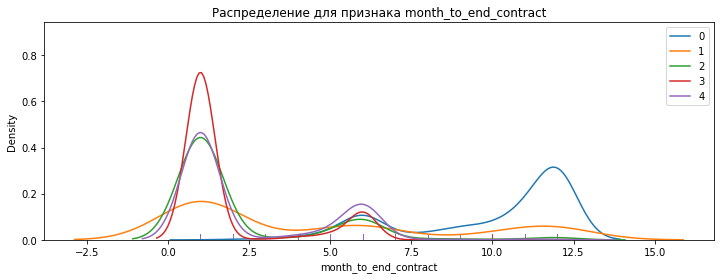

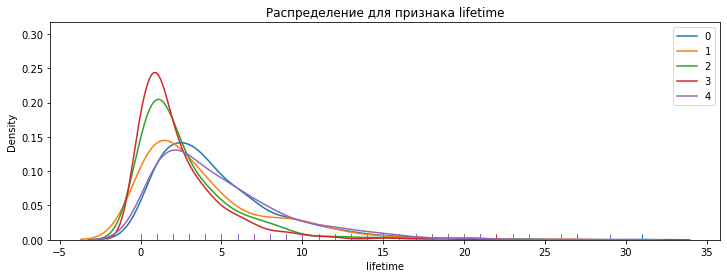

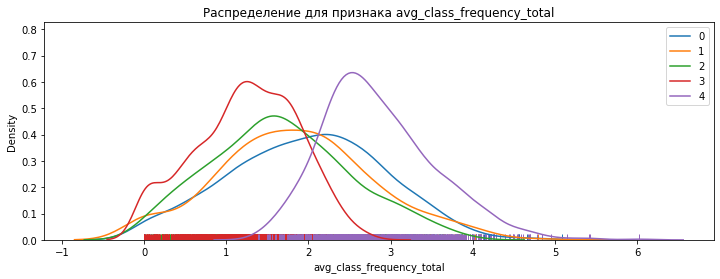

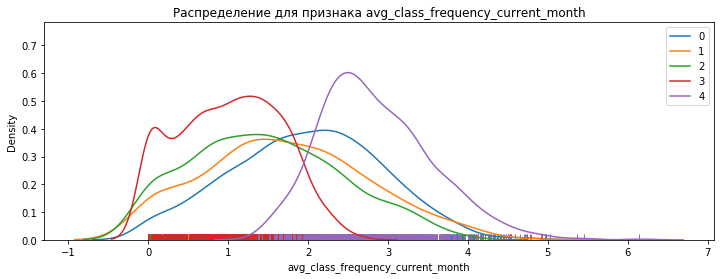

In [31]:
for i in list_num:
    plt.figure(figsize = (12, 4))
    plt.title(i)
    for j in range(0,5):
        sns.distplot(data.query('claster_km == @j')[i],
                    hist=False,
                    rug=True,
                    kde_kws={'label':'Кластер'+ str(i)})
        plt.legend(labels = ('0', '1', '2', '3', '4'))
    plt.title('Распределение для признака ' + i)
    plt.show

Отметим характерные черты клиентов по кластерам:

**"0"**:

- Пользуются партнерскими программами
- Посещают групповые занятия чаще
- Чаще Приобретают абонемент на 12 месяцев
- В среднем старше
- Среднее число тренировок в неделю 2

**"1"**:

- Не имеют контактного телефона
- Среднее число тренировок в неделю (за весь период) - 1.8
- Среднее число тренировок в неделю (за последний месяц) - 1.7

**"2"**:

- Не живут и не работают в районе клуба
- Среднее число тренировок в неделю (за весь период) - 1.7
- Среднее число тренировок в неделю (за последний месяц) - 1.4

**"3"**:

- В среднем моложе
- Малыйсрок до окончания абонемента
- Новые клиенты
- Среднее число тренировок в неделю (за весь период)  - 1.2
- Среднее число тренировок в неделю (за последний месяц) - 1

**"4"**:

- Среднее число тренировок в неделю - 2.8
- Посещают групповые часто, но реже чем в кластере "1"

Посмотрим, как распределены доли клиентов в оттоке среди кластеров:

In [32]:
data.groupby('claster_km').agg({'churn':'mean'}).sort_values('churn', ascending=False).style.format({'churn': '{:.0%}'})

,churn
claster_km,
3,51%
2,44%
1,27%
4,7%
0,3%


Наибольший процент оттока в кластере "3" - 51% и кластере "2" - 44%. Наиболее надёжный кластер "0" - всего 2% клиентов ушли в отток, еще один надёжный кластер "4" - в отток ушли 7% клиентов.

Соотнеся эти данные с распределелением признакаков, можно сказать, что на отток клиентов влияет регулярность посещений (в надёжных кластерах - не реже 2х раз в неделю) и посещение групповых занятий. Так же влияет длительность абонемента и возможность его приобретения по партнерской программе.

**Выводы:**

Мы разделили клиентов на 5 кластеров и получили для этих кластеров характерные отличия, а также выделили кластеры "в оттоке" и "надёжные". Соотнеся эти данные с распределелением признакаков, можно сказать, что на отток клиентов влияет регулярность посещений (в надёжных кластерах - не реже 2х раз в неделю) и посещение групповых занятий. Так же влияет длительность абонемента и возможность его приобретения по партнерской программе.

## Выводы и рекомендации

**Выводы:**

По результатам исследовательского анализа данных мы сделали предположение, что клиенты "в оттоке" покупают абонемент на один месяц, причем не по партнерской программе для работаделей или "друзей" членов клуба, а, вероятно, за полную стоимость. В течении этого месяца они редко посещают групповые занятия и реже пользуются дополнительными услугами. Посещение клуба нерегулярное, часто после покупки абонемента клиент вообще не посещает клуб и уходит в отток.

Для построения модели прогнозирования оттока клиентов мы обучили модели методами логистической регрессии и случайного леса. На основании метрик на валидационной выборке лучше себя показала модель обученная методом логистической регрессии.

На основании алгоритка K-Means спрогнозированы 5 кластеов клиентов ("0", "1", "2", "3", "4"). Характерные черты признаков:

**"0"**:

- Пользуются партнерскими программами
- Посещают групповые занятия чаще
- Чаще Приобретают абонемент на 12 месяцев
- В среднем старше
- Среднее число тренировок в неделю 2

**"1"**:

- Не имеют контактного телефона
- Среднее число тренировок в неделю (за весь период) - 1.8
- Среднее число тренировок в неделю (за последний месяц) - 1.7

**"2"**:

- Не живут и не работают в районе клуба
- Среднее число тренировок в неделю (за весь период) - 1.7
- Среднее число тренировок в неделю (за последний месяц) - 1.4

**"3"**:

- В среднем моложе
- Малыйсрок до окончания абонемента
- Новые клиенты
- Среднее число тренировок в неделю (за весь период)  - 1.2
- Среднее число тренировок в неделю (за последний месяц) - 1

**"4"**:

- Среднее число тренировок в неделю - 2.8
- Посещают групповые часто, но реже чем в кластере "1"

Наибольший процент оттока в кластере "3" - 51% и кластере "2" - 44%. Наиболее надёжный кластер "0" - всего 2% клиентов ушли в отток, еще один надёжный кластер "4" - в отток ушли 7% клиентов.

Соотнеся эти данные с распределелением признакаков, можно сказать, что на отток клиентов влияет регулярность посещений (в надёжных кластерах - не реже 2х раз в неделю) и посещение групповых занятий. Так же влияет длительность абонемента и возможность его приобретения по партнерской программе.

**Рекомендации**:

- Вызвать у новых клиентов с короткими абонементами дополнительную лояльность. Например сделать скидку на персональную тренировку или платное групповое занятие.  
- Стимулировать посещение фитнес-центров на уровне не реже 2 раз в неделю, например скидками на дополнительные услуги (хорошо тренеруешься - подари себе массаж по приятной цене)
- Поппуляризировать групповые тренировки


